# Assignment 3 - Data Set Description
The questions below relate to the data files associated with the contest with the title 'DengAI: Predicting Disease Spread' published at the following website. 
https://www.drivendata.org/competitions/44/dengai-predicting-disease-spread/data/

Anyone can join the contest and showcase your skills. To know about contest submissions visit the following webpage
https://www.drivendata.org/competitions/44/dengai-predicting-disease-spread/submissions/
You can showcase your Machine Learning skills by ranking top in the contest. 

Problem description:
Your goal is to predict the total_cases label for each (city, year, weekofyear) in the test set. There are two cities, San Juan and Iquitos, with test data for each city spanning 5 and 3 years respectively. You will make one submission that contains predictions for both cities. The data for each city have been concatenated along with a city column indicating the source: sj for San Juan and iq for Iquitos. The test set is a pure future hold-out, meaning the test data are sequential and non-overlapping with any of the training data. Throughout, missing values have been filled as NaNs.

Assignment:
The goal is achieved through three subsequent Assignments 1, 2 and 3, all using the same dataset


The features in this dataset
You are provided the following set of information on a (year, weekofyear) timescale:

(Where appropriate, units are provided as a _unit suffix on the feature name.)

City and date indicators

    city – City abbreviations: sj for San Juan and iq for Iquitos
    week_start_date – Date given in yyyy-mm-dd format

NOAA's GHCN daily climate data weather station measurements

    station_max_temp_c – Maximum temperature
    station_min_temp_c – Minimum temperature
    station_avg_temp_c – Average temperature
    station_precip_mm – Total precipitation
    station_diur_temp_rng_c – Diurnal temperature range
    
PERSIANN satellite precipitation measurements (0.25x0.25 degree scale)

    precipitation_amt_mm – Total precipitation

NOAA's NCEP Climate Forecast System Reanalysis measurements (0.5x0.5 degree scale)

    reanalysis_sat_precip_amt_mm – Total precipitation
    reanalysis_dew_point_temp_k – Mean dew point temperature
    reanalysis_air_temp_k – Mean air temperature
    reanalysis_relative_humidity_percent – Mean relative humidity
    reanalysis_specific_humidity_g_per_kg – Mean specific humidity
    reanalysis_precip_amt_kg_per_m2 – Total precipitation
    reanalysis_max_air_temp_k – Maximum air temperature
    reanalysis_min_air_temp_k – Minimum air temperature
    reanalysis_avg_temp_k – Average air temperature
    reanalysis_tdtr_k – Diurnal temperature range

Satellite vegetation - Normalized difference vegetation index (NDVI) - NOAA's CDR Normalized Difference Vegetation Index (0.5x0.5 degree scale) measurements

    ndvi_se – Pixel southeast of city centroid
    ndvi_sw – Pixel southwest of city centroid
    ndvi_ne – Pixel northeast of city centroid
    ndvi_nw – Pixel northwest of city centroid

# Assignment 3 - Questions
Use the merged data frame from Assignment 1 (and 2) for this assignment

This Assignment focuses on data preprocessing and model building. Continue with the datasets loaded in Assignment 1 and 2 (or reload with same steps and create merged data frame). In this assignment you need to use both i). Linear SVR regressor and ii) SVR with Linear kernel. Provide your intepretations.


Submit the following for this assignment: 
1. .ipynb and .html formats of Jupyter notebook code with outputs and 
2. the submission_format.csv with your predictions

Note:
Missing each of these will take out 0.1 point at each applicable place:
1. Using full file path (you can use path=input() to set path and use it in os.chdir())
2. Not labeling plots (x-label, y-label, title), not presentable plots (too small/oversized/overflow/unreadbale labels etc)
3. Not having observation below each plot, dataframe output, model result/evaluation output where applies. Observation should be pointed, should not be generic statement and should be backed up with technical evidence from the results obtained.
4. Not showing each question as markdown, then answer, then observation as markdown
5. Printing full/lengthy dataframe
6. Importing excess libraries and not used in code



**1. Write a brief statement: Is it required to consider the repeating features in the model? (For example: precipitation_amt_mm and reanalysis_sat_precip_amt_mm. Similarly there are others). List which features you will choose in this model. Select the required columns in the dataframe and drop the others.**

In [661]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.svm import LinearSVR
from math import sqrt
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import uniform as sp_rand
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVR

In [662]:
#import the data
df=pd.read_csv("C:/Users/18132/Desktop/My Docs/DSP/Ass_3/df_merged.csv")

In [663]:
#Removing the outliers using inter-quantiles
Q1=df['total_cases'].quantile(0.25)
Q3=df['total_cases'].quantile(0.75)
IQR=Q3-Q1
print(IQR)
df_out=pd.DataFrame()
df_out=df[(df['total_cases']<(Q1-1.5*IQR))|(df['total_cases']>(Q3+1.5*IQR))]
print(df_out.shape)

23.0
(124, 25)


In [664]:
df_noout=df[~((df['total_cases']<(Q1-1.5*IQR))|(df['total_cases']>(Q3+1.5*IQR)))]
df_noout.shape

(1332, 25)

In [665]:
#Checking if we have nans
df_noout.isna().sum()

city                          0
year                          0
weekofyear                    0
week_start_date               0
ndvi_ne                       0
ndvi_nw                       0
ndvi_se                       0
ndvi_sw                       0
prec_amt_mm                   0
re_an_air_temp_k              0
re_an_avg_temp_k              0
re_an_dew_point_temp_k        0
re_an_max_air_temp_k          0
re_an_min_air_temp_k          0
re_an_precip_amt_kg_per_m2    0
re_an_relative_hd_percent     0
re_an_sat_precip_amt_mm       0
re_an_specific_hd_g_per_kg    0
re_an_tdtr_k                  0
stn_avg_temp_c                0
stn_diur_temp_rng_c           0
stn_max_temp_c                0
stn_min_temp_c                0
stn_precip_mm                 0
total_cases                   0
dtype: int64

In [666]:
#As correlation don't run for strings and also there is no point to check correlation of year and 
#week of year with other variables,as they are not integer values , but kind of factor variables, so we removed it and create a dataset
df_new=df_noout.drop(columns=['city','week_start_date','year','weekofyear'])

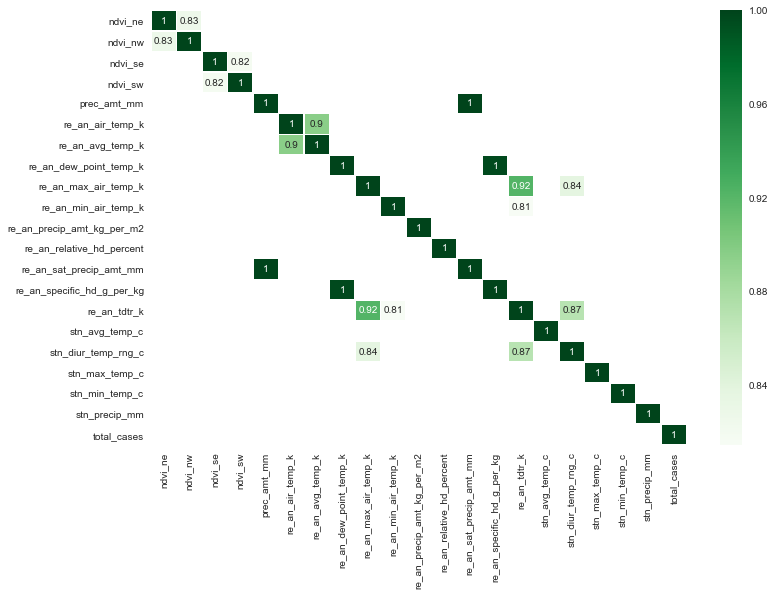

In [667]:
corr = df_new.corr().abs() #Calculate correlation and convert them to positive for plot
c = corr[corr>=.8] #Take only highly correlated values, i.e. more than 0.8
plt.figure(figsize=(12,8)) #Set the size of figure
sns.heatmap(c,annot=True, cmap="Greens",linewidths=.5) #Create correlation plot using heatmap

**From the above plot, we can see the variables which are highly correlated, so we can do feature selection based on this:**

1.ndvi_nw: Considered this between ndvi_nw and ndvi_ne, as both are highly correlated, so will keep one, also its near by direction, it might have same pixels.

2.ndvi_sw: Considered this between ndvi_sw and ndvi_se, as both are highly correlated, so will keep one, also its near by direction, it might have same pixels.

3.re_an_air_temp: Considered this between re_an_air_temp and re_an_avg_temp_k, as both are highly correlated and also both specify average air temperature.

4.re_an_tdtr_k: Considered this, as it is highly correlated with re_an_min_air_temp_k, re_an_max_air_temp_k,stn_diur_temp_rng_c, also as we know diurnal temperature is difference of minimum and maximyum temperature.

5.re_an_sat_precip_amt_mm: Considered this between re_an_sat_precip_amt_mm and prec_amt_mm, as they are highly correlated and also both are displaying the same values.

6.re_an_specific_hd_g_per_kg:Considered this between re_an_specific_hd_g_per_kg and re_an_dew point_temp_k, as they are highly correlated and also both of them refer to water vapour in environment.

7.re_an_precip_amt_kg_per_m2: Considered as it is not highly correlated with any variable

8.re_an_relative_hd_percent:Considered, as not highly correlated with any variable, also it represents vapour to vapour and to dry air like specific humidity.

9.Considered stn_avg_temp_c, stn_max_temp_c,stn_min_temp_c and stn_percip_mm, as none of them are highly correlated with other variables.

10.week_start_date: We are not considering week_start_date, as we can get the same value by using the combination of week_of_year and year, so will kepp these two instead of week_start_date.

In [668]:
#Dataframe with selected variable
df_sel=df_noout.drop(columns=['ndvi_ne','ndvi_se','re_an_avg_temp_k','re_an_min_air_temp_k','re_an_max_air_temp_k','stn_diur_temp_rng_c','prec_amt_mm','re_an_dew_point_temp_k','week_start_date'])
df_sel.shape

(1332, 16)

**2. Preprocess the data**
    1. Encode the  categorical features
    2. Abbreviate the column names
    3. Standardize the numerical features
    4. Handle NaNs (either fill them with Median values or make a better choice if available)
    5. Convert percentage to value/100 (check which option gives better result, as-is or divided/100)
    6. Scale the vegetation features (ndvi*) as 0, 1 (0 <= 0.25 and 1 > 0.25) as it is in scale of 0 to 0.5. Retain as is or use other scaling based on how model performs.
    7. Make an 80-20 train-test split 

**#Convert column with percentage to value/100**

In [602]:
df_sel['re_an_relative_hd_percent']=(df_sel['re_an_relative_hd_percent']/ 100).round(2)

**#Scale the vegetation features (ndvi*) as 0, 1 (0 <= 0.25 and 1 > 0.25) as it is in scale of 0 to 0.5**

In [669]:
df_sel.loc[df_sel['ndvi_nw']<=0.25,'sc_ndvi_nw']=0
df_sel.loc[df_sel['ndvi_nw']>0.25,'sc_ndvi_nw']=1
df_sel.loc[df_sel['ndvi_sw']<=0.25,'sc_ndvi_sw']=0
df_sel.loc[df_sel['ndvi_sw']>0.25,'sc_ndvi_sw']=1

In [670]:
df_sel=df_sel.drop(columns=['ndvi_nw','ndvi_sw'])

In [671]:
df_sel.head()

,city,year,weekofyear,re_an_air_temp_k,re_an_precip_amt_kg_per_m2,re_an_relative_hd_percent,re_an_sat_precip_amt_mm,re_an_specific_hd_g_per_kg,re_an_tdtr_k,stn_avg_temp_c,stn_max_temp_c,stn_min_temp_c,stn_precip_mm,total_cases,sc_ndvi_nw,sc_ndvi_sw
0,sj,1990,18,297.572857,32.00,73.365714,12.42,14.012857,2.628571,25.442857,29.4,20.0,16.0,4,0.0,0.0
1,sj,1990,19,298.211429,17.94,77.368571,22.82,15.372857,2.371429,26.714286,31.7,22.2,8.6,5,0.0,0.0
2,sj,1990,20,298.781429,26.10,82.052857,34.54,16.848571,2.300000,26.714286,32.2,22.8,41.4,4,0.0,0.0
3,sj,1990,21,298.987143,13.90,80.337143,15.36,16.672857,2.428571,27.471429,33.3,23.3,4.0,3,0.0,0.0
4,sj,1990,22,299.518571,12.20,80.460000,7.52,17.210000,3.014286,28.942857,35.0,23.9,5.8,6,1.0,0.0


In [672]:
#Abbreviating the column names
df_sel_ab=df_sel
df_sel_ab.columns=df_sel.columns.str.replace('re_an','r')
df_sel_ab.columns=df_sel.columns.str.replace('stn','s')
df_sel_ab.columns=df_sel.columns.str.replace('ndvi','n')
df_sel_ab.head()

,city,year,weekofyear,r_air_temp_k,r_precip_amt_kg_per_m2,r_relative_hd_percent,r_sat_precip_amt_mm,r_specific_hd_g_per_kg,r_tdtr_k,s_avg_temp_c,s_max_temp_c,s_min_temp_c,s_precip_mm,total_cases,sc_n_nw,sc_n_sw
0,sj,1990,18,297.572857,32.00,73.365714,12.42,14.012857,2.628571,25.442857,29.4,20.0,16.0,4,0.0,0.0
1,sj,1990,19,298.211429,17.94,77.368571,22.82,15.372857,2.371429,26.714286,31.7,22.2,8.6,5,0.0,0.0
2,sj,1990,20,298.781429,26.10,82.052857,34.54,16.848571,2.300000,26.714286,32.2,22.8,41.4,4,0.0,0.0
3,sj,1990,21,298.987143,13.90,80.337143,15.36,16.672857,2.428571,27.471429,33.3,23.3,4.0,3,0.0,0.0
4,sj,1990,22,299.518571,12.20,80.460000,7.52,17.210000,3.014286,28.942857,35.0,23.9,5.8,6,1.0,0.0


Checking the maximum datapoints around which value by using histogram, so that we can create the stratified split accordingly

Text(0.5, 1.0, 'Histogram of total cases')

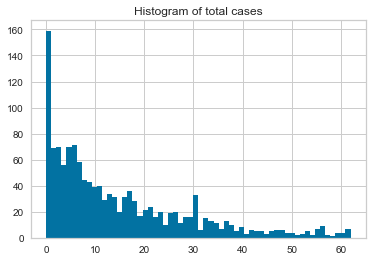

In [673]:
df_sel['total_cases'].hist(bins=60)
plt.title("Histogram of total cases")

Create a total cases attribute to choose the reliable datapoint and remove the biases like as we can see in above plot some datapoints near by 60 can be biased one

[1. 2. 3. 4. 0.]


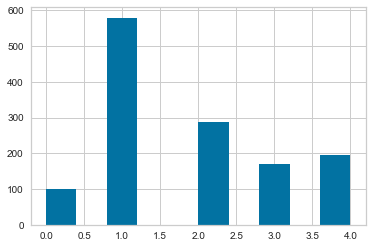

In [674]:
df_sel["total_cases_cat"]=np.ceil(df_sel["total_cases"]/10) 
df_sel["total_cases_cat"].where(df_sel["total_cases_cat"]<4,4.0,inplace=True)
df_sel["total_cases_cat"].hist()
print(df_sel["total_cases_cat"].unique())

The data is divided into following category with some percentage, the same should be there for split

In [675]:
df_sel["total_cases_cat"].value_counts()/len(df_sel) 

1.0    0.434685
2.0    0.215465
4.0    0.147147
3.0    0.127628
0.0    0.075075
Name: total_cases_cat, dtype: float64

**Now split the data into 80:20 split by using stratified split method so that both train and test can have equal percentage of all categories**

In [676]:
split=StratifiedShuffleSplit(n_splits=4,test_size=0.2,random_state=42) 
for train_index,test_index in split.split(df_sel,df_sel["total_cases_cat"]):
    train_set=df_sel.iloc[train_index]
    test_set=df_sel.iloc[test_index]
print(train_set["total_cases_cat"].value_counts()/len(train_set)) 
test_set["total_cases_cat"].value_counts()/len(test_set)

1.0    0.434742
2.0    0.215023
4.0    0.147418
3.0    0.127700
0.0    0.075117
Name: total_cases_cat, dtype: float64


1.0    0.434457
2.0    0.217228
4.0    0.146067
3.0    0.127341
0.0    0.074906
Name: total_cases_cat, dtype: float64

**Encoding the categorical variable like city,year and weekofyear using label encoder,as it is the most efficient method, with one hot encoding and get dummies, it will create multiple column for each category and less efficient**

In [677]:
le = preprocessing.LabelEncoder()
train_set['year']=le.fit_transform(train_set['year'])
test_set['year']=le.transform(test_set['year'])
train_set['city']=le.fit_transform(train_set['city'])
test_set['city']=le.transform(test_set['city'])
train_set['weekofyear']=le.fit_transform(train_set['weekofyear'])
test_set['weekofyear']=le.transform(test_set['weekofyear'])

C:\Users\18132\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\18132\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\18132\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in t

In [678]:
train_set.head()

,city,year,weekofyear,r_air_temp_k,r_precip_amt_kg_per_m2,r_relative_hd_percent,r_sat_precip_amt_mm,r_specific_hd_g_per_kg,r_tdtr_k,s_avg_temp_c,s_max_temp_c,s_min_temp_c,s_precip_mm,total_cases,sc_n_nw,sc_n_sw,total_cases_cat
1076,0,13,10,296.680000,186.80,96.171429,47.97,17.515714,6.242857,26.700000,32.0,22.1,98.4,4,0.0,0.0,1.0
571,1,11,16,298.751429,22.36,76.581429,35.69,15.630000,3.128571,27.200000,33.3,22.8,20.6,6,0.0,0.0,1.0
459,1,9,7,295.938571,8.70,72.251429,23.90,12.492857,2.714286,24.042857,28.9,18.9,0.0,37,0.0,0.0,4.0
1336,0,18,10,298.017143,32.17,89.268571,96.05,17.505714,9.014286,26.250000,33.2,22.2,64.4,9,0.0,0.0,1.0
310,1,6,15,297.852857,24.22,78.311429,46.16,15.185714,2.300000,26.128571,32.2,21.1,8.9,11,0.0,0.0,2.0


In [679]:
test_set.head()

,city,year,weekofyear,r_air_temp_k,r_precip_amt_kg_per_m2,r_relative_hd_percent,r_sat_precip_amt_mm,r_specific_hd_g_per_kg,r_tdtr_k,s_avg_temp_c,s_max_temp_c,s_min_temp_c,s_precip_mm,total_cases,sc_n_nw,sc_n_sw,total_cases_cat
1081,0,13,15,296.747143,43.85,95.992857,51.14,17.534286,4.757143,27.720000,34.2,22.4,49.0,0,0.0,1.0,0.0
320,1,6,25,299.641429,22.50,80.907143,15.99,17.468571,2.242857,27.685714,32.8,23.3,19.3,6,0.0,0.0,1.0
818,1,16,2,298.401429,41.50,78.720000,74.41,15.794286,2.428571,24.714286,30.6,20.6,101.1,19,0.0,0.0,2.0
778,1,15,14,299.190000,23.70,77.650000,33.69,16.315714,3.385714,27.400000,32.8,22.8,21.1,1,0.0,0.0,1.0
1062,0,12,48,298.324286,49.20,90.662857,49.69,18.105714,8.000000,28.500000,33.7,22.9,46.0,38,1.0,1.0,4.0


**Creating X and y for train and test dataset so that we can use have predictors as x and target as y variable for our model**

In [680]:
X_train=train_set.drop(columns=['total_cases','total_cases_cat'])
X_test=test_set.drop(columns=['total_cases','total_cases_cat'])
y_train=train_set['total_cases']
y_test=test_set['total_cases']

Did the scaling of all the columns of train and test except city,year and week of year, as they are already done while encoding, train is fit transformed and test is only transformed as it should not learn from train dataset

In [681]:
sc=StandardScaler()
X_train.iloc[:,3:13]=sc.fit_transform(X_train.iloc[:,3:13])
X_test.iloc[:,3:13]=sc.transform(X_test.iloc[:,3:13])

Converted them to numpy array, in order to use them in the model, as we need array form to feed in model

In [682]:
X_train_np=X_train.to_numpy()
X_test_np=X_test.to_numpy()
y_train_np=y_train.to_numpy()
y_test_np=y_test.to_numpy()

**3. Build a Linear SVR regressor, train the model**
    1. Evaluate your model based on applicable metrics. Show the metric(s) you chose and why you chose this(these) metrics.
    2. List the hyper-parameters that can be tuned in Linear SVR. Explain the meaning of each hyper-parameter. Show the code along with comments on the parameter value chosen (use class presentation, discussion notes, some online reading) and why this value was chosen. Show the improvement you achieved in model accuracy. 
    3. Plot Learning curve and provide insights

Run the **Linear SVR** for the dataset with default values to see the errors of the predictions

In [461]:
lin_svr=LinearSVR(random_state=42) 
lin_svr.fit(X_train_np,y_train_np)

C:\Users\18132\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LinearSVR(C=1.0, dual=True, epsilon=0.0, fit_intercept=True,
          intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=1000,
          random_state=42, tol=0.0001, verbose=0)

In [462]:
y_pred=lin_svr.predict(X_test_np) 
print("Root Mean squared error test: %.2f" %sqrt(mean_squared_error(y_test_np, y_pred)))

Root Mean squared error test: 12.71


**Random Search Algorithm:**

To improve the accuracy of the model, we are running the random search algorithm, as it help us to get the better result with more efficiency as compared to grid search, as in this, all the combination will not be executed, but ceratin random combination will be compared and get the output.

**Model parameters:**

tol: Considered, so that once the model reached the convergence, we can stop the training 

max_iter: Considered, to control the maximum number of iterations and make the model more efficient

C: Considered, as it is the regularization parameter, and to increase it by keeping loss function constant, can help us solve optimization problem.

loss: loss function is used to decrease the error for every iteration and try to reach the minimum error


In [514]:
param_grid = {'tol':sp_rand(),'max_iter': [1000,3000,5000,7000],'C':[0.1,0.5,1.0,1.5]}
rsearch = RandomizedSearchCV(lin_svr, param_distributions=param_grid)
rsearch.fit(X_train_np,y_train_np)

C:\Users\18132\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


RandomizedSearchCV(cv='warn', error_score='raise-deprecating',
                   estimator=LinearSVR(C=1.0, dual=True, epsilon=0.0,
                                       fit_intercept=True,
                                       intercept_scaling=1.0,
                                       loss='epsilon_insensitive',
                                       max_iter=1000, random_state=42,
                                       tol=0.0001, verbose=0),
                   iid='warn', n_iter=10, n_jobs=None,
                   param_distributions={'C': [0.1, 0.5, 1.0, 1.5],
                                        'max_iter': [1000, 3000, 5000, 7000],
                                        'tol': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000029F1688AE48>},
                   pre_dispatch='2*n_jobs', random_state=None, refit=True,
                   return_train_score=False, scoring=None, verbose=0)

In [515]:
rsearch.best_estimator_ 

LinearSVR(C=1.5, dual=True, epsilon=0.0, fit_intercept=True,
          intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=7000,
          random_state=42, tol=0.21259288689866462, verbose=0)

**RMSE of improved model**

In [518]:
lin_svr1=LinearSVR(C=1.5, dual=True, epsilon=0.0, fit_intercept=True,
          intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=7000,
          random_state=42, tol=0.1509176995763768, verbose=0)
lin_svr1.fit(X_train_np,y_train_np)
y_pred1=lin_svr1.predict(X_test_np)
y_predtr=lin_svr1.predict(X_train_np)
print("Root Mean squared error test: %.2f" %sqrt(mean_squared_error(y_test_np, y_pred1)))
print("Root Mean squared error train: %.2f" %sqrt(mean_squared_error(y_train_np, y_predtr)))

Root Mean squared error test: 12.15
Root Mean squared error train: 12.14


**Learning Curve for improved linear SVR model**

In [519]:
def plot_learning_curves(model, X_train, y_train):
    train_errors,test_errors = [], []
    for m in range(1, len(X_train)):
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_test_predict = model.predict(X_test_np)
        train_errors.append(mean_squared_error(y_train[:m], y_train_predict))
        test_errors.append(mean_squared_error(y_test_np, y_test_predict))
    plt.plot(np.sqrt(train_errors), "r-+", linewidth=2, label="train")
    plt.plot(np.sqrt(test_errors), "b-", linewidth=3, label="test")

**Curve for second model i.e. lin_svr1, as it performed better than first model i.e. lin_svr, we can see that through RMSE**

Text(0.5, 1.0, 'Learning curve of Linear SVR')

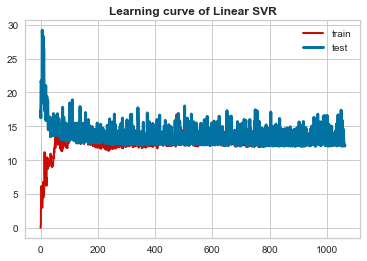

In [650]:
plot_learning_curves(lin_svr1,X_train_np,y_train_np)
plt.legend()
plt.title("Learning curve of Linear SVR",fontweight='bold')

**As we can see there is no gap between the test error and train error, which shows that the model is performim=ng well, but the dependent variable might not be linear**

**4. Build a SVR model with Linear Kernel, train the model**
    1. Evaluate your model based on applicable metrics. Show the metric(s) you chose and why you chose this(these) metrics.
    2. List the hyper-parameters that can be tuned in SVR model with Linear Kernel. Show the code along with comments on the parameter value chosen (use class presentation, discussion notes, some online reading) and why this value was chosen. Show the improvement you achieved in model accuracy. 
    3. List the hyper-parameters that can be tuned in SVR model with Linear Kernel. Show the code along with comments on the parameter value chosen (use class presentation, discussion notes, some online reading) and why this value was chosen. Show the improvement you achieved in model accuracy. 

**SVR with linear**

In [521]:
ker_svr= SVR(kernel='linear')
ker_svr.fit(X_train_np,y_train_np)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
    gamma='auto_deprecated', kernel='linear', max_iter=-1, shrinking=True,
    tol=0.001, verbose=False)

In [522]:
y_predk=ker_svr.predict(X_test_np)
print("Root Mean squared error test: %.2f" %sqrt(mean_squared_error(y_test_np, y_predk)))

Root Mean squared error test: 12.58


**MOdel Parameter**

tol: Considered, so that once the model reached the convergence, we can stop the training 

max_iter: Considered, to control the maximum number of iterations and make the model more efficient

C: Considered, as it is the regularization parameter, and to increase it by keeping loss function constant, can help us solve optimization problem.


In [538]:
param_grid = {'tol':[0.00001,0.0001,0.001,0.01],'max_iter': [1000,3000,5000,7000,9000],'C':[0.6,1,1.5,2.0]}
rsearch1 = RandomizedSearchCV(ker_svr, param_distributions=param_grid)
rsearch1.fit(X_train_np,y_train_np)

C:\Users\18132\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\18132\Anaconda3\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\18132\Anaconda3\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\18132\Anaconda3\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\18132\Anaconda3\li

RandomizedSearchCV(cv='warn', error_score='raise-deprecating',
                   estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                                 epsilon=0.1, gamma='auto_deprecated',
                                 kernel='linear', max_iter=-1, shrinking=True,
                                 tol=0.001, verbose=False),
                   iid='warn', n_iter=10, n_jobs=None,
                   param_distributions={'C': [0.6, 1, 1.5, 2.0],
                                        'max_iter': [1000, 3000, 5000, 7000,
                                                     9000],
                                        'tol': [1e-05, 0.0001, 0.001, 0.01]},
                   pre_dispatch='2*n_jobs', random_state=None, refit=True,
                   return_train_score=False, scoring=None, verbose=0)

In [539]:
rsearch1.best_estimator_ 

SVR(C=2.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
    gamma='auto_deprecated', kernel='linear', max_iter=7000, shrinking=True,
    tol=0.0001, verbose=False)

**Updated SVR Model with kernel**

In [585]:
ker_svr1=SVR(C=1.6, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
    gamma='auto_deprecated', kernel='linear', max_iter=7000, shrinking=True,
    tol=0.0001, verbose=False)
ker_svr1.fit(X_train_np,y_train_np)


C:\Users\18132\Anaconda3\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=7000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


SVR(C=1.6, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
    gamma='auto_deprecated', kernel='linear', max_iter=7000, shrinking=True,
    tol=0.0001, verbose=False)

In [625]:
y_predk1=ker_svr1.predict(X_test_np)
y_predktr=ker_svr1.predict(X_train_np)
print("Root Mean squared error test: %.2f" %sqrt(mean_squared_error(y_test_np, y_predk1)))
print("Root Mean squared error train: %.2f" %sqrt(mean_squared_error(y_train_np, y_predktr)))

Root Mean squared error test: 12.55
Root Mean squared error train: 12.22


**Learning curve for ker_svr1 as it is better than ker_svr i.e. first model, as we can see through RMSE**

C:\Users\18132\Anaconda3\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=7000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\18132\Anaconda3\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=7000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\18132\Anaconda3\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=7000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\18132\Anaconda3\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=7000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\18132\Anaconda3\lib\site-packag

C:\Users\18132\Anaconda3\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=7000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\18132\Anaconda3\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=7000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\18132\Anaconda3\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=7000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\18132\Anaconda3\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=7000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\18132\Anaconda3\lib\site-packag

C:\Users\18132\Anaconda3\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=7000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\18132\Anaconda3\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=7000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\18132\Anaconda3\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=7000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\18132\Anaconda3\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=7000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\18132\Anaconda3\lib\site-packag

C:\Users\18132\Anaconda3\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=7000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\18132\Anaconda3\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=7000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\18132\Anaconda3\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=7000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\18132\Anaconda3\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=7000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\18132\Anaconda3\lib\site-packag

C:\Users\18132\Anaconda3\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=7000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\18132\Anaconda3\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=7000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\18132\Anaconda3\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=7000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\18132\Anaconda3\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=7000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\18132\Anaconda3\lib\site-packag

C:\Users\18132\Anaconda3\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=7000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\18132\Anaconda3\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=7000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\18132\Anaconda3\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=7000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\18132\Anaconda3\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=7000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\18132\Anaconda3\lib\site-packag

C:\Users\18132\Anaconda3\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=7000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\18132\Anaconda3\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=7000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\18132\Anaconda3\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=7000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\18132\Anaconda3\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=7000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\18132\Anaconda3\lib\site-packag

C:\Users\18132\Anaconda3\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=7000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\18132\Anaconda3\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=7000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\18132\Anaconda3\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=7000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\18132\Anaconda3\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=7000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\18132\Anaconda3\lib\site-packag

C:\Users\18132\Anaconda3\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=7000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\18132\Anaconda3\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=7000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\18132\Anaconda3\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=7000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\18132\Anaconda3\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=7000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\18132\Anaconda3\lib\site-packag

C:\Users\18132\Anaconda3\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=7000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\18132\Anaconda3\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=7000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\18132\Anaconda3\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=7000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\18132\Anaconda3\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=7000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\18132\Anaconda3\lib\site-packag

C:\Users\18132\Anaconda3\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=7000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\18132\Anaconda3\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=7000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\18132\Anaconda3\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=7000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\18132\Anaconda3\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=7000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\18132\Anaconda3\lib\site-packag

C:\Users\18132\Anaconda3\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=7000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\18132\Anaconda3\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=7000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\18132\Anaconda3\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=7000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\18132\Anaconda3\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=7000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\18132\Anaconda3\lib\site-packag

C:\Users\18132\Anaconda3\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=7000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\18132\Anaconda3\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=7000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\18132\Anaconda3\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=7000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\18132\Anaconda3\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=7000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\18132\Anaconda3\lib\site-packag

C:\Users\18132\Anaconda3\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=7000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\18132\Anaconda3\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=7000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\18132\Anaconda3\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=7000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\18132\Anaconda3\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=7000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\18132\Anaconda3\lib\site-packag

C:\Users\18132\Anaconda3\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=7000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\18132\Anaconda3\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=7000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\18132\Anaconda3\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=7000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\18132\Anaconda3\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=7000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\18132\Anaconda3\lib\site-packag

C:\Users\18132\Anaconda3\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=7000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\18132\Anaconda3\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=7000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\18132\Anaconda3\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=7000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\18132\Anaconda3\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=7000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\18132\Anaconda3\lib\site-packag

C:\Users\18132\Anaconda3\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=7000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\18132\Anaconda3\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=7000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\18132\Anaconda3\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=7000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\18132\Anaconda3\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=7000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\18132\Anaconda3\lib\site-packag

C:\Users\18132\Anaconda3\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=7000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\18132\Anaconda3\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=7000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\18132\Anaconda3\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=7000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\18132\Anaconda3\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=7000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\18132\Anaconda3\lib\site-packag

C:\Users\18132\Anaconda3\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=7000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\18132\Anaconda3\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=7000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\18132\Anaconda3\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=7000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\18132\Anaconda3\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=7000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\18132\Anaconda3\lib\site-packag

C:\Users\18132\Anaconda3\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=7000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\18132\Anaconda3\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=7000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\18132\Anaconda3\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=7000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\18132\Anaconda3\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=7000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\18132\Anaconda3\lib\site-packag

C:\Users\18132\Anaconda3\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=7000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\18132\Anaconda3\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=7000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\18132\Anaconda3\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=7000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\18132\Anaconda3\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=7000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\18132\Anaconda3\lib\site-packag

C:\Users\18132\Anaconda3\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=7000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\18132\Anaconda3\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=7000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\18132\Anaconda3\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=7000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\18132\Anaconda3\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=7000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\18132\Anaconda3\lib\site-packag

C:\Users\18132\Anaconda3\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=7000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\18132\Anaconda3\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=7000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\18132\Anaconda3\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=7000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\18132\Anaconda3\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=7000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\18132\Anaconda3\lib\site-packag

C:\Users\18132\Anaconda3\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=7000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\18132\Anaconda3\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=7000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\18132\Anaconda3\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=7000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\18132\Anaconda3\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=7000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\18132\Anaconda3\lib\site-packag

C:\Users\18132\Anaconda3\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=7000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\18132\Anaconda3\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=7000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\18132\Anaconda3\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=7000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\18132\Anaconda3\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=7000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\18132\Anaconda3\lib\site-packag

C:\Users\18132\Anaconda3\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=7000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\18132\Anaconda3\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=7000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\18132\Anaconda3\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=7000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\18132\Anaconda3\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=7000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\18132\Anaconda3\lib\site-packag

C:\Users\18132\Anaconda3\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=7000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\18132\Anaconda3\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=7000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\18132\Anaconda3\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=7000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\18132\Anaconda3\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=7000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\18132\Anaconda3\lib\site-packag

C:\Users\18132\Anaconda3\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=7000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\18132\Anaconda3\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=7000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\18132\Anaconda3\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=7000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\18132\Anaconda3\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=7000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\18132\Anaconda3\lib\site-packag

Text(0.5, 1.0, 'Learning curve for SVR with linear kernel')

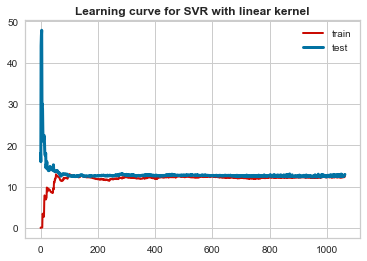

In [649]:
plot_learning_curves(ker_svr1,X_train_np,y_train_np)
plt.legend()
plt.title("Learning curve for SVR with linear kernel",fontweight='bold')

**As we can see there is no gap between the test error and train error, which shows that the model is performim=ng well, but the dependent variable might not be linear**

**5. Create a submission file which has predictions for both cities in the submission format prescribed by the contest at the link https://www.drivendata.org/competitions/44/dengai-predicting-disease-spread/data/. To get this, you need to use the file 'dengue_features_test.csv'**

In [683]:
sub_test=pd.read_csv("dengue_features_test.csv")
sub_test=sub_test.fillna(method='ffill')

In [684]:
#Encoding week of year for new test file
sub_test['weekofyear']=le.transform(sub_test['weekofyear'])
#Encoding city of new test file
train_set['city'] = le.fit_transform(train_set['city'])
sub_test['city'] = sub_test['city'].map(lambda s: '<unknown>' if s not in le.classes_ else s)
le.classes_ = np.append(le.classes_, '<unknown>')
sub_test['city'] = le.transform(sub_test['city'])
#Encoding year of new test file
train_set['year'] = le.fit_transform(train_set['year'])
sub_test['year'] = sub_test['year'].map(lambda s: '<unknown>' if s not in le.classes_ else s)
le.classes_ = np.append(le.classes_, '<unknown>')
sub_test['year'] = le.transform(sub_test['year'])

C:\Users\18132\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\Users\18132\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  """
C:\Users\18132\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [616]:
#renaming the columns as we did it for train data
sub_test.columns=sub_test.columns.str.replace('station','stn')
sub_test.columns=sub_test.columns.str.replace('reanalysis','re_an')
sub_test.columns=sub_test.columns.str.replace('humidity','hd')
sub_test.columns=sub_test.columns.str.replace('precipitation','prec')
sub_test.head()

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,prec_amt_mm,re_an_air_temp_k,...,re_an_precip_amt_kg_per_m2,re_an_relative_hd_percent,re_an_sat_precip_amt_mm,re_an_specific_hd_g_per_kg,re_an_tdtr_k,stn_avg_temp_c,stn_diur_temp_rng_c,stn_max_temp_c,stn_min_temp_c,stn_precip_mm
0,2,21,17,2008-04-29,-0.0189,-0.018900,0.102729,0.091200,78.60,298.492857,...,25.37,78.781429,78.60,15.918571,3.128571,26.528571,7.057143,33.3,21.7,75.2
1,2,21,18,2008-05-06,-0.0180,-0.012400,0.082043,0.072314,12.56,298.475714,...,21.83,78.230000,12.56,15.791429,2.571429,26.071429,5.557143,30.0,22.2,34.3
2,2,21,19,2008-05-13,-0.0015,-0.012400,0.151083,0.091529,3.66,299.455714,...,4.12,78.270000,3.66,16.674286,4.428571,27.928571,7.785714,32.8,22.8,3.0
3,2,21,20,2008-05-20,-0.0015,-0.019867,0.124329,0.125686,0.00,299.690000,...,2.20,73.015714,0.00,15.775714,4.342857,28.057143,6.271429,33.3,24.4,0.3
4,2,21,21,2008-05-27,0.0568,0.039833,0.062267,0.075914,0.76,299.780000,...,4.36,74.084286,0.76,16.137143,3.542857,27.614286,7.085714,33.3,23.3,84.1


In [617]:
#dropping the columns which we dropped for train dataset
sub_test=sub_test.drop(columns=['ndvi_ne','ndvi_se','re_an_avg_temp_k','re_an_min_air_temp_k','re_an_max_air_temp_k','stn_diur_temp_rng_c','prec_amt_mm','re_an_dew_point_temp_k','week_start_date'])
sub_test.shape

(416, 15)

In [618]:
# converting the humidity column to percentage as we did the same for train data
sub_test['re_an_relative_hd_percent']=(sub_test['re_an_relative_hd_percent']/ 100).round(2)

In [619]:
#Encoding vegetation variables
sub_test.loc[sub_test['ndvi_nw']<=0.25,'sc_ndvi_nw']=0
sub_test.loc[sub_test['ndvi_nw']>0.25,'sc_ndvi_nw']=1
sub_test.loc[sub_test['ndvi_sw']<=0.25,'sc_ndvi_sw']=0
sub_test.loc[sub_test['ndvi_sw']>0.25,'sc_ndvi_sw']=1

In [620]:
sub_test=sub_test.drop(columns=['ndvi_nw','ndvi_sw'])
sub_test.head()

,city,year,weekofyear,re_an_air_temp_k,re_an_precip_amt_kg_per_m2,re_an_relative_hd_percent,re_an_sat_precip_amt_mm,re_an_specific_hd_g_per_kg,re_an_tdtr_k,stn_avg_temp_c,stn_max_temp_c,stn_min_temp_c,stn_precip_mm,sc_ndvi_nw,sc_ndvi_sw
0,2,21,17,298.492857,25.37,0.79,78.60,15.918571,3.128571,26.528571,33.3,21.7,75.2,0.0,0.0
1,2,21,18,298.475714,21.83,0.78,12.56,15.791429,2.571429,26.071429,30.0,22.2,34.3,0.0,0.0
2,2,21,19,299.455714,4.12,0.78,3.66,16.674286,4.428571,27.928571,32.8,22.8,3.0,0.0,0.0
3,2,21,20,299.690000,2.20,0.73,0.00,15.775714,4.342857,28.057143,33.3,24.4,0.3,0.0,0.0
4,2,21,21,299.780000,4.36,0.74,0.76,16.137143,3.542857,27.614286,33.3,23.3,84.1,0.0,0.0


In [621]:
#Scaling new test data
sub_test.iloc[:,3:13]=sc.transform(sub_test.iloc[:,3:13])
sub_test_np=sub_test.to_numpy()

In [623]:
#predicting the total cases fro new test dataset using the best model i.e. linear SVR after changing the paramenters
sub_predict=lin_svr1.predict(sub_test_np)

In [624]:
sub_test['total_cases']=sub_predict
sub_test.head()

,city,year,weekofyear,re_an_air_temp_k,re_an_precip_amt_kg_per_m2,re_an_relative_hd_percent,re_an_sat_precip_amt_mm,re_an_specific_hd_g_per_kg,re_an_tdtr_k,stn_avg_temp_c,stn_max_temp_c,stn_min_temp_c,stn_precip_mm,sc_ndvi_nw,sc_ndvi_sw,total_cases
0,2,21,17,-0.083871,-0.342414,-0.480221,0.761668,-0.517545,-0.542192,-0.492810,0.421692,-0.210982,0.666266,0.0,0.0,10.000916
1,2,21,18,-0.096662,-0.421293,-0.616568,-0.778568,-0.600315,-0.696252,-0.853920,-1.244455,0.114287,-0.136730,0.0,0.0,10.737430
2,2,21,19,0.634558,-0.815910,-0.616568,-0.986141,-0.025577,-0.182720,0.613088,0.169246,0.504610,-0.751247,0.0,0.0,9.788217
3,2,21,20,0.809369,-0.858692,-1.298300,-1.071502,-0.610545,-0.206422,0.714651,0.421692,1.545471,-0.804256,0.0,0.0,8.203661
4,2,21,21,0.876522,-0.810563,-1.161954,-1.053777,-0.375256,-0.427635,0.364825,0.421692,0.829879,0.841001,0.0,0.0,10.597447


In [637]:
submission_file=pd.read_csv("dengue_features_test.csv")
submission_file=submission_file.fillna(method='ffill')

In [656]:
submission_file['total_cases']=sub_predict
submission_file['total_cases']=submission_file['total_cases'].astype(int)
submission_file=submission_file[['city','year','weekofyear','total_cases']]

In [658]:
submission_file.to_csv(r'C:\Users\18132\Desktop\My Docs\DSP\Ass_3\submission_file.csv', index = False)

**7.Compare the Model Evaluation metric of SGD (Assignment 2), Linear SVR and SVR with Linear Kernel and state which model performed better along with reason why you consider so.**

In [542]:
df3=pd.DataFrame(np.array([['SGD Model','12.11','12.33'],['Linear SVR',round(sqrt(mean_squared_error(y_train_np, y_predtr)),2),round(sqrt(mean_squared_error(y_test_np, y_pred1)),2)],['SVR with Linear kernel',round(sqrt(mean_squared_error(y_train_np, y_predktr)),2),round(sqrt(mean_squared_error(y_test_np, y_predk1)),2)]]),columns=['Model', 'RMSE_train', 'RMSE_test'])
df3.head()

,Model,RMSE_train,RMSE_test
0,SGD Model,12.11,12.33
1,Linear SVR,12.14,12.15
2,SVR with Linear kernel,12.22,12.55


**As we can see the RMSE of test set of Linear SVR is the lowest, we can say that is the best model out of all three models**